<a href="https://colab.research.google.com/github/Lazuardis/Optimization/blob/main/Modelling_Transshipment_Problem_Beef_Distribution_Network_in_Bogor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Transshipment Problem - Beef Distribution Network in Bogor
#### **Python for Optimization: Leveraging Pyomo to solve Transshipment Problem**

**Introduction**

Hi!, in this notebook we will demonstrate the code aspect of discussion taken place from this article series.



Please read the article to grasp a better context before delving into this notebook

The series are consisted by several chapters that are discussing about implementation of Python in Optimization, specifically about linear programming leveraging Transshipment Problem as selected study case.

This notebook futhermore is representative of what specifically talked through on chapter 2 of the series.


### Installing Pyomo

Pyomo will be the python-based framework in doing and solving the transshipment problem. It quite heavy for initial install I guess, and will also be the solver (we will talk bout it below) so I recommend for you to have all this being undertaken in your local machine rather something like google collab.

In [2]:
pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00


**Importing the necessary library**

Import mainly pyomo environment to make us able model the problem, solver factory to select the solver, and pandas to load our data.

In [3]:
import pyomo.environ as pyo #main pyomo environment
from pyomo.environ import * #import all
from pyomo.opt import SolverFactory #pyomo solver tools
import pandas as pd

##**Uploading and Exploring The Input Data**

Uploading the data is crucial as the format should be adjusted. For this exercise, we have prepared the data for you to download on GitHub link here:


Please do examine carefully the way the data being structured and formatted. We will have several data put on different sheets, further discussion below.

In [4]:
o_h_tcost = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'origin_hub_tcost')
o_h_ccost = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'origin_hub_ccost')
h_d_tcost = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'hub_destination_tcost')
h_d_ccost = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'hub_destination_ccost')
capacity = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'origin_capacity')
demand = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'destination_demand')
hub = pd.read_excel('input_transportation_case.xlsx', sheet_name = 'hub_id')

So we have uploaded 7 data, all from one same excel file you have downloaded. And all of them we have saved into customized variable with definition below:

*   o_h_tcost: Origin-Hub Transportation Cost. Transportation cost per kilogram meat from specific origin to specific hub **(Rp/Kg)**
*   o_h_ccost: Origin-Hub Carbon Cost. Carbon cost per kilogram meat from specific origin to specific hub **(Rp/Kg)**

These two matrix have exactly same array size, only cost_per_unit value is different, let's examine the way it looks




In [5]:
o_h_tcost.head()

,path,origin,hub,cost_per_unit
0,0,1,1,27.62
1,1,1,2,11.88
2,2,1,3,46.18
3,3,2,1,25.23
4,4,2,2,9.56


I guess the table above pretty intuitive. Just one note is that you could see column 'path' here basically is an indexing of each origin-hub pairing. In total, there would be 24 path for there are 8 origin x 3 hub combination

moving on, we have another dataset:

*   h_d_tcost: Hub-Destination Transportation Cost. Transportation cost from specific origin to specific hub **(Rp)**
*   h_d_tcost: Hub-Destination Carbon Cost. Carbon cost from specific origin to specific hub **(Rp)**

**Attention!**. As you can see the unit here is not Rp/Kg, but rather only Rp. This is deliberate to make it simpler, as it is assumed the problem is **Single Allocation**, meaning that every destination would be fulfilled by exactly one hub. So we calculate and adjust the grand total of transportation and carbon cost respective to each of destination given demand.

Let's see the data, and how the last column is titled 'cost' instead of 'cost_per_unit'


In [ ]:
h_d_tcost.head()

,path,hub,destination,cost
0,0,1,1,181021.67
1,1,1,2,1627577.94
2,2,1,3,188180.72
3,3,1,4,185112.55
4,4,1,5,675350.69


There will be total 18 path for there are 3 hub x 6 destination combination

Moving on, let's examine other dataset. Below is the production capacity of each origin.

In [ ]:
capacity

,origin,capacity
0,1,169754
1,2,178846
2,3,162236
3,4,183397
4,5,198187
5,6,276006
6,7,187265
7,8,174523


And here how demand table for each destination looks like:

In [ ]:
demand

,destination,demand
0,1,14551
1,2,98538
2,3,14551
3,4,14551
4,5,43675
5,6,94620


Followed by hub. We only showing the ID, as for the hub is uncapacitated. Actually this very variable might not be needed. But it's nicer to give the reader context since we have explained both origin and destination prior.

In [ ]:
hub

,hub
0,1
1,2
2,3


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Create The Mathematical Model: Define the Decision Variable

Consider that your problem need to constructed within a variable called model. This model is created using Pyomo. And from it, you define the model decision variable.

We will be having two decision variable, namely:

*   **X(i,j)** - The amount of meat in kilogram being transported from origin i to hub j. Value in Integer
*   **Y(j,k)** - The decision whether hub j is selected to accomodate the demand of destination k. Value in Binary


Now, let's get define all of it in code cell below








In [ ]:
#model
model = pyo.ConcreteModel()

# variable
# X(i,j)
model.X = pyo.Var(range(len(o_h_tcost)), within=Integers, bounds=(0, None))
X = model.X
# Explanation: the X decision variable is an array with length of range(len(o_h_tcost)) or 24, defined as integer, with possible value ranging from 0 to infinity


# Y(j,k)
model.Y = pyo.Var(range(len(h_d_tcost)),within=Binary)
Y = model.Y

# Explanation: the X decision variable is an array with length ofrange(len(h_d_tcost)) or 18, defined as binary variable

#Carbon emission per unit, fixed variable
CE = 2.94

**Note**
In this very example, we reconstruct the way we define X(i,j) and Y(j,k) while coding it in Pyomo Python.

Instead of using two indexes for each X and Y variable, we modify it to only have one index. Suppose now it's X(path), and Y(path).

The logic will still be the same, as you could see like how dataset o_h_tcost is presented above, origin 1 to hub 1 is denoted by path 0. So instead of calling it X(i,j) = X(1,1), we now call it as X(path) = X(0), and so on so forth.

This choice is not due to Pyomo incapability to facilitate multi-indexing for a variable, but rather to make it simple for us in designing the variable and prior dataset.

## Defining Constraints

We have defined parameters being read from the excel files of datasets, and we have defined the decision variables. Next we will discuss about constraints.

Let's examine the constraint given below:

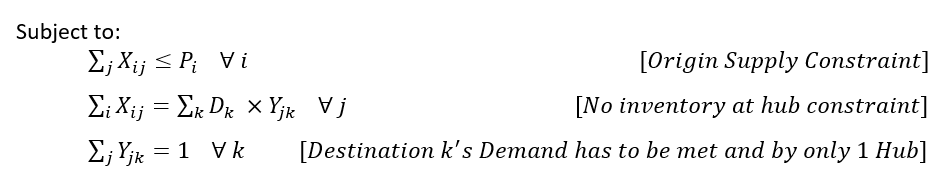



**First Constraint: Origin Supply Constraint**

Making sure that meat (in kilograms) transported from origin to hub does not exceed the capacity of each origin



In [ ]:
#Origin Supply Constraint
#What is being produced and delivered to hub should not exceed origin capacity
model.origincap = pyo.ConstraintList()
for origin_node in capacity.origin:

    total_sent_to_hub = sum([X[sent_to_hub] for sent_to_hub in o_h_tcost.path[o_h_tcost.origin == origin_node]])
    model.origincap.add(expr = total_sent_to_hub <= capacity.capacity[origin_node-1] )



**Second Constraint: No inventory at hub constraint**

Making sure that meat transferred to and delivered from are equal for each hub. Meaning that in the end, hub will not facilitate any meat leftover. All being received will be sent



In [ ]:
#No inventory at hub constraint
#what has been sent to hub, all of them has to be delivered to destination(s)

model.noinventory = pyo.ConstraintList()
for hub_node in hub.hub:
    total_sent_from_origin = sum([X[sent_from_ori] for sent_from_ori in o_h_tcost.path[o_h_tcost.hub == hub_node] ])
    total_demand_to_satisfy = 0
    for destination in demand.destination:
        total_demand_to_satisfy += sum([Y[decision_to_satisfy] * demand.demand[destination-1]
                                        for decision_to_satisfy in h_d_tcost.path[(h_d_tcost.hub == hub_node) & (h_d_tcost.destination == destination)]])
    model.noinventory.add(expr = total_sent_from_origin == total_demand_to_satisfy )


**Third Constraint: Each Destination demand has to be satisfied by one hub**

Making sure it follows the problem being single allocation. Any destination can not receive meat from two or more different hubs

In [ ]:
# One destination satisfied by one hub constraint
model.singledist = pyo.ConstraintList()
for dest_node in demand.destination:
    model.singledist.add(expr = sum([Y[hub_chosen] for hub_chosen in h_d_tcost.path[h_d_tcost.destination == dest_node]]) == 1)

## Defining Objective Function

Now as all variables, parameters and constraints are well constructed. We now have to define the objective function.

Let's see how it defined in mathematical expression:



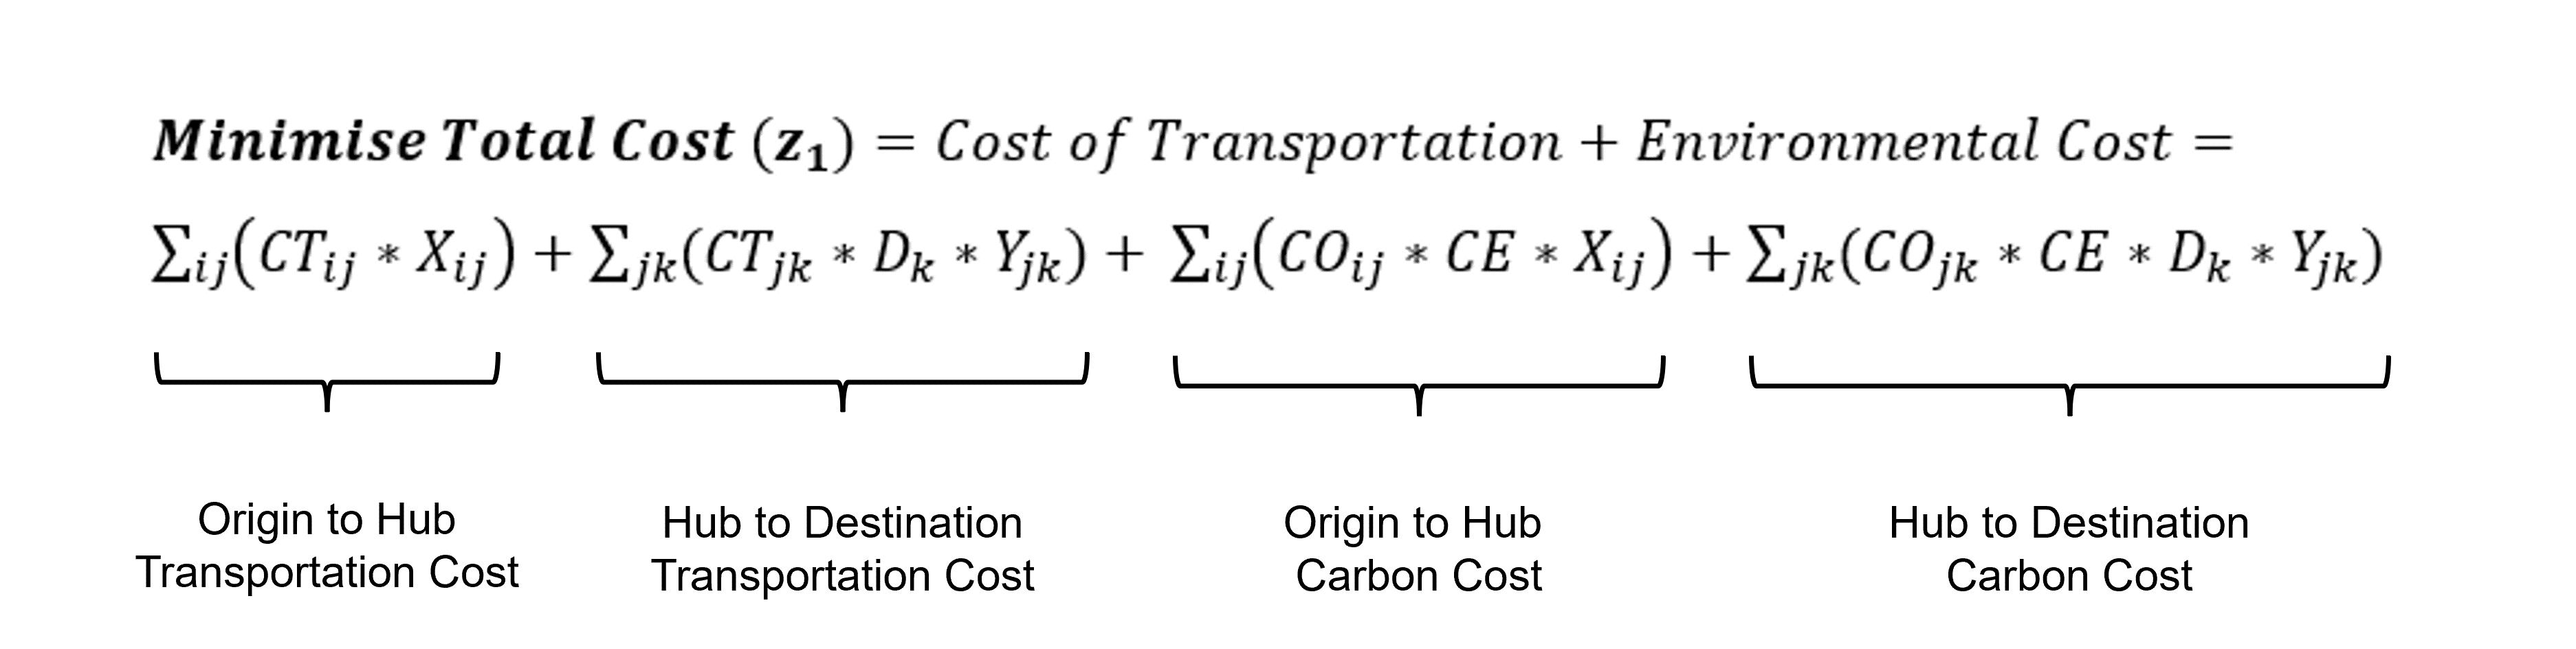

And below is how we construct this objective function in python pyomo.

in Pyomo, the objective function is the object of the model.

In [ ]:
#objective function
total_tcost_o_h = sum([X[ij] * o_h_tcost.cost_per_unit[ij] for ij in o_h_tcost.path])
total_tcost_h_d = sum([Y[jk] * h_d_tcost.cost[jk] for jk in h_d_tcost.path])
total_ccost_o_h = sum([X[ij] * CE * o_h_ccost.cost_per_unit[ij] for ij in o_h_ccost.path])
total_ccost_h_d = sum([Y[jk] * CE * h_d_ccost.cost[jk] for jk in h_d_ccost.path])

model.obj =  pyo.Objective(expr = total_tcost_o_h + total_tcost_h_d + total_ccost_o_h + total_ccost_h_d , sense=minimize)

### **Getting Ready in Solving It: Installing the Solver**

What is Solver?, solver holds as the entity that will solve the problem we have defined, it is a digital set of algorithm comprising of approach/method.

In theoritical ground, you might heard about Simplex or Branch-and-Bound being used to solve a linear programming model. These two methods are 'solver' by their means.

However what we are currently dealing here is more about the digital one, mostly commercial, and mostly work in blackbox. So we could not now the procedural way how to do it manually like we when learning about Simplex or BnB

#### **Selecting Solver: CBC**
CBC (Coin-or branch and cut) is one alternative of solver, an open-source mixed integer linear programming solver initally written in C++.

We are using this particular solver as it suits our problem. However you could also install and use other solver as long as you pay attention that it could be used for your specific model problem.

Let's take a look below


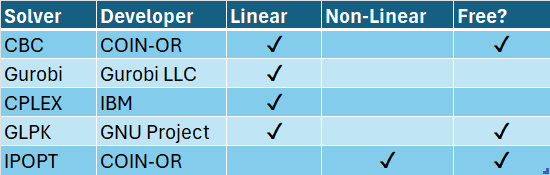

It is apparent that, choosing solver depends on the requirement of the problem modeler. And perhaps the money situation, for we are definitely opting for free stuff, are we not?

But don't worry, you could explore and find that even for commercial options like Gurobi and CPLEX, they offer some free trial installation with simple terms and conditions. Just check out their website for further information about this. But for now, let's settle with CBC.

### **Installing CBC**

So, installing solver would depend as well whether you are using online cloud infrastructure like Google Colab, or if you just basically using your own machine.

If you are using your own machine, you need to download the solver package first from the official website of the developers. Extract the zip file and select the directory as the solver path (we will discuss it later)

However for this case, we will guide you how to install solver if we are using Google Colab, for we need to run specific code as follows, to download the solver package.

In [ ]:
!apt-get install -y -qq coinor-cbc

Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to unpack .../4-coinor-libcbc3_2.10.7+ds1-1_amd64.deb ...
Unpacking coinor-libcbc3:

Note:
For other type of solver, I would recommend you to check this Google Colab file if you are keen to explore other scenario of using other alternatives

[CHECK HERE](https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/01.02-Running-Pyomo-on-Google-Colab.ipynb)

#### **Set the installed CBC as the main solver for Pyomo**

As for now the CBC has been installed, you could refer the solver using Pyomo `SolverFactory()` method like below

In [ ]:
opt = SolverFactory('cbc', executable='/usr/bin/cbc')

### **...and Solve!**

Upon finishing loading the solver, now we use `opt.solve()` to solve our defined model saved in `model`



In [ ]:
results = opt.solve(model)

# print the overarching result for the optimization model we have just solved
model.pprint()

results.write()

2 Var Declarations
    X : Size=24, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key : Lower : Value    : Upper : Fixed : Stale : Domain
          0 :     0 :      0.0 :  None : False : False : Integers
          1 :     0 :      0.0 :  None : False : False : Integers
          2 :     0 :      0.0 :  None : False : False : Integers
          3 :     0 :      0.0 :  None : False : False : Integers
          4 :     0 : 178846.0 :  None : False : False : Integers
          5 :     0 :      0.0 :  None : False : False : Integers
          6 :     0 :      0.0 :  None : False : False : Integers
          7 :     0 :      0.0 :  None : False : False : Integers
          8 :     0 :      0.0 :  None : False : False : Integers
          9 :     0 :      0.0 :  None : False : False : Integers
         10 :     0 :      0.0 :  None : False : False : Integers
         11 :     0 :      0.0 :  None : False : False : Integers
         12 :  

test `o_h_tcost` test test

**Interpreting the result:**

It's a bit all over the place isn't it. But don't worry, we will get you to pay attention only for the essential information for us to be able to prescribe out of the problem.

The objective function shows that the solution is 4849996.9068 which can be seen from section `Problem Information` above. This solution is deemed optimal as it is specified in section `Solution Information` likewise above.

So, if you look at `2 Var Declarations` above, it shows the decision variable X(path) and Y(path) shaped upon optimization is complete.

If you look at the column of value, most of them are 0, meaning that they  neither be selected as chosen path (for Y) nor any meat is delivered through that path (for X)

Let's take example in variable X, Key 4 is showing value of 178846.0. This means specified amount of meat in kg is delivered through path with index 4. Likewise for variable Y, Key 6 having value of 1 indicates that path with index 6 is chosen to deliver meat from specified hub to specified destination.

The extent to which origin and which hub is being represented by path index for variable X, we could refer to `o_h_tcost` table earlier, the same for variable Y, you could refer to `h_d_tcost`.

Anyway, to make it more comprehendible, we want to do some data structuring by extracting the solution taken from Pyomo into our prior dataframe. By adding the solution as a new column, hopefully it is now lot easier to understand. Please check the code below

In [ ]:
o_h_tcost['Xij'] = [pyo.value(X[g]) for g in o_h_tcost.path]
h_d_tcost['Yjk'] = [pyo.value(Y[g]) for g in h_d_tcost.path]


hub['utilized_size'] = o_h_tcost.groupby('hub')['Xij'].sum().reset_index()['Xij']

origin = pd.DataFrame(o_h_tcost['origin'].unique(), columns=['origin'])
origin['Xij'] = o_h_tcost.groupby('origin')['Xij'].sum().reset_index()['Xij']


destination = pd.DataFrame(h_d_tcost['destination'].unique(), columns=['destination'])
destination['hub'] = destination['destination'].map(h_d_tcost.loc[h_d_tcost['Yjk'] == 1].set_index('destination')['hub'])

Below is the Origin to Hub Matrix, now equipped with the decision variable solution of Xij. Now we know which origin to hub is being selected to deliver how much kilogram of meat.

In [ ]:
o_h_tcost

,path,origin,hub,cost_per_unit,Xij
0,0,1,1,27.62,0.0
1,1,1,2,11.88,0.0
2,2,1,3,46.18,0.0
3,3,2,1,25.23,0.0
4,4,2,2,9.56,178846.0
5,5,2,3,43.86,0.0
6,6,3,1,35.85,0.0
7,7,3,2,49.90,0.0
8,8,3,3,14.06,0.0
9,9,4,1,22.21,0.0


Again, same goes for Hub to Destination. If you are paying attention, you could see how each destination is only being satisfied by a single hub.

In [ ]:
h_d_tcost

,path,hub,destination,cost,Yjk
0,0,1,1,181021.67,0.0
1,1,1,2,1627577.94,0.0
2,2,1,3,188180.72,0.0
3,3,1,4,185112.55,0.0
4,4,1,5,675350.69,0.0
5,5,1,6,1170483.20,0.0
6,6,2,1,95113.08,1.0
7,7,2,2,408625.95,1.0
8,8,2,3,64431.44,1.0
9,9,2,4,60340.56,1.0


Let's see how each hub is being utilized, kilogram-wise

In [ ]:
hub

,hub,utilized_size
0,1,0.0
1,2,280486.0
2,3,0.0


And let's see how each origin in total supplying any hub

In [ ]:
origin

,origin,Xij
0,1,0.0
1,2,178846.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,101640.0
7,8,0.0


And there you go, the information to let you know which hub each of destination is using

In [ ]:
destination

,destination,hub
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2
5,6,2


## Developing Alternative Scenario: Implementing Fair Market and Anti-Monopoly

Observing the result above, we are witnessing how the origin and hub selection is quite unbalanced in the sense of only few entities are actually opted for the network.

Precisely, 2 origins are selected out of 8 available, and 1 hub is selected out of 3.

Despite this is the most optimal, most cheap when it comes to the network cost, realisticly speaking it might be not likely for stakeholder to act upon it.

Therefore, we try to modify the assumption, improving it to be more representative to the complex and non-technically disruptive reality full of stakeholder. These assumptions are represented as additional constraints to the mathematical model. Which can be described as follows:



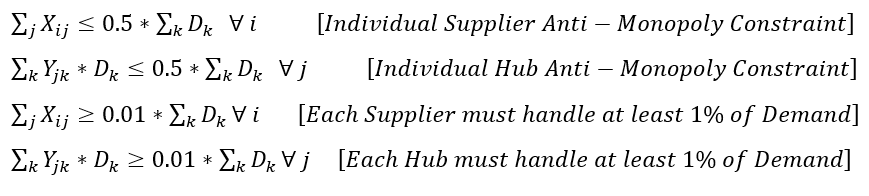

**Fourth Constraint: Anti-Monopoly for Origin/Supplier**

This constraint make sure that no single Origin will accomodate more than 50% of total demand

\

**Fifth Constraint: Anti-Monopoly for Hub**

This constraint make sure that no single Hub will accomodate more than 50% of total demand

\

**Sixth Constraint: Minimum Demand for Supplier**

Make sure that at least an origin will handle 1% of demand (you could adjust the percentage accordingly)

\

**Seventh Constraint: Minimum Demand for Hub**

Make sure that at least a hub will handle 1% of demand (you could adjust the percentage accordingly)

\

below is the code hands-on in designing those constraints into Pyomo

In [ ]:
# Individual Supplier Anti-Monopoly Constraint
model.maxantimonosup = pyo.ConstraintList()
for origin_node in capacity.origin:
    total_sent_to_hub = sum([X[sent_to_hub] for sent_to_hub in o_h_tcost.path[o_h_tcost.origin == origin_node]])
    maximum_demand = 0.5 * sum([demand.demand[k-1] for k in demand.destination])

    model.maxantimonosup.add(expr= total_sent_to_hub <= maximum_demand)


# Each supplier must handle at least 5% of demand
model.minantimonosup = pyo.ConstraintList()
for origin_node in capacity.origin:
    total_sent_to_hub = sum([X[sent_to_hub] for sent_to_hub in o_h_tcost.path[o_h_tcost.origin == origin_node]])
    minimum_demand = 0.05 * sum([demand.demand[k-1] for k in demand.destination])

    model.minantimonosup.add(expr= total_sent_to_hub >= minimum_demand)


# Individual Hub Anti-Monopoly Constraint
model.maxantimonohub = pyo.ConstraintList()
for hub_node in hub.hub:
    total_demand_to_satisfy = 0
    for destination in demand.destination:
        total_demand_to_satisfy += sum([Y[decision_to_satisfy] * demand.demand[destination-1]
                                        for decision_to_satisfy in h_d_tcost.path[(h_d_tcost.hub == hub_node) & (h_d_tcost.destination == destination)]])
    maximum_demand = 0.5 * sum([demand.demand[k-1] for k in demand.destination])
    model.maxantimonohub.add(expr= total_demand_to_satisfy <= maximum_demand )

# Each hub must handle at least 5% of demand
model.minantimonohub = pyo.ConstraintList()
for hub_node in hub.hub:
    total_demand_to_satisfy = 0
    for destination in demand.destination:
        total_demand_to_satisfy += sum([Y[decision_to_satisfy] * demand.demand[destination-1]
                                        for decision_to_satisfy in h_d_tcost.path[(h_d_tcost.hub == hub_node) & (h_d_tcost.destination == destination)]])
    minimum_demand = 0.01 * sum([demand.demand[k-1] for k in demand.destination])
    model.minantimonohub.add(expr= total_demand_to_satisfy >= minimum_demand )

### Let's re-run the model optimization

Now with constraints addition

In [ ]:
results = opt.solve(model)

# print the overarching result for the optimization model we have just solved
model.pprint()
results.write()

2 Var Declarations
    X : Size=24, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key : Lower : Value    : Upper : Fixed : Stale : Domain
          0 :     0 :      0.0 :  None : False : False : Integers
          1 :     0 :  14025.0 :  None : False : False : Integers
          2 :     0 :      0.0 :  None : False : False : Integers
          3 :     0 :      0.0 :  None : False : False : Integers
          4 :     0 :  85565.0 :  None : False : False : Integers
          5 :     0 :      0.0 :  None : False : False : Integers
          6 :     0 :      0.0 :  None : False : False : Integers
          7 :     0 :      0.0 :  None : False : False : Integers
          8 :     0 :  14025.0 :  None : False : False : Integers
          9 :     0 :  13499.0 :  None : False : False : Integers
         10 :     0 :      0.0 :  None : False : False : Integers
         11 :     0 :    526.0 :  None : False : False : Integers
         12 :  

In [ ]:
o_h_tcost['Xij'] = [pyo.value(X[g]) for g in o_h_tcost.path]
h_d_tcost['Yjk'] = [pyo.value(Y[g]) for g in h_d_tcost.path]


hub['utilized_size'] = o_h_tcost.groupby('hub')['Xij'].sum().reset_index()['Xij']

origin = pd.DataFrame(o_h_tcost['origin'].unique(), columns=['origin'])
origin['Xij'] = o_h_tcost.groupby('origin')['Xij'].sum().reset_index()['Xij']


destination = pd.DataFrame(h_d_tcost['destination'].unique(), columns=['destination'])
destination['hub'] = destination['destination'].map(h_d_tcost.loc[h_d_tcost['Yjk'] == 1].set_index('destination')['hub'])

In [ ]:
origin

,origin,Xij
0,1,14025.0
1,2,85565.0
2,3,14025.0
3,4,14025.0
4,5,14025.0
5,6,110771.0
6,7,14025.0
7,8,14025.0


In [ ]:
destination

,destination,hub
0,1,3
1,2,2
2,3,2
3,4,2
4,5,1
5,6,1


As it can be seen, each origin now selected to deliver meats, and all hub are utilized. Despite the distribution network is inevitably becoming more costly (now is 6327989.737), this might be better for the context of macro economy of the Bogor City!.